In [2]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

#from sklearn.model_selection import train_test_split 
#from sklearn.linear_model import LinearRegression
#from sklearn import metrics
import statsmodels.api as sm

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on HMS Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-a-16-103.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 32
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [3]:
def linear_regression(x, y, output=True):
    """Do Linear Regression.
    Return Incercept, beta,
    and R2 and stdev of beta
    output: If True: print output"""
    X = sm.add_constant(x_clean)
    model = sm.OLS(y_clean, X)
    results = model.fit()
    
    intercept, corrcoef =  results.params
    r_sq = results.rsquared
    cis = results.conf_int(alpha=0.05, cols=None)
    
    if output:
        print('intercept:', intercept)
        print('slope:', corrcoef)
        print('coefficient of determination:', r_sq)
    return intercept, corrcoef, r_sq, cis

def set_color_df(df, dct, clst_col = "clst", color_col = "color",
                default_c="silver"):
    """Create Color Column color_col in Dataframe df,
    based on dictionary dct matching clst in df"""
    df[color_col]=default_c
    
    for k in dct.keys():
        idx = df[clst_col].str.contains(k)
        df.loc[idx, color_col] = dct[k]
    return df

# Make Plots of inferred qpAdm fractions
Requires
1) qpAdm Runs
2) Saving qpAdm results as .csv (done over in ./viz_qpAdm, there is an option for the functino)

### 1) Load the qpAdm Results

In [4]:
path_qpAdm =  "./output/qpAdm/3wayIberia/3wayIberia.csv"
df_3way = pd.read_csv(path_qpAdm, sep = "\t")

### 2) Load the .anno File and merge

In [5]:
path_anno = "/n/groups/reich/hringbauer/Data/v42.3.anno.csv"
df_anno = pd.read_csv(path_anno)
df_all = pd.merge(df_3way, df_anno, left_on="target", right_on="iid")

### Keep only the best coerage Indivdual
df_all = df_all.sort_values(by="n_cov_snp", ascending=False)
df_all = df_all.drop_duplicates(subset="Master ID")
print(f"Reduced to {len(df_all)} unique Individuals.")

Reduced to 73 unique Individuals.


### Set Colors

In [6]:
dct = {"Celtiberian":"yellow",
       "Iberian":"red",
       "Tartessian":"blue",
        "Punic":"magenta",
        "Greek":"orange",
        "Hellenistic":"orange"}

df_all = set_color_df(df_all, dct, clst_col = "clst", 
                      color_col = "color", default_c="silver")
df_all.to_csv("./output/figures/qpAdm/qpAdm_3way_iberia.csv", sep="\t", index=False)

### Do Figures

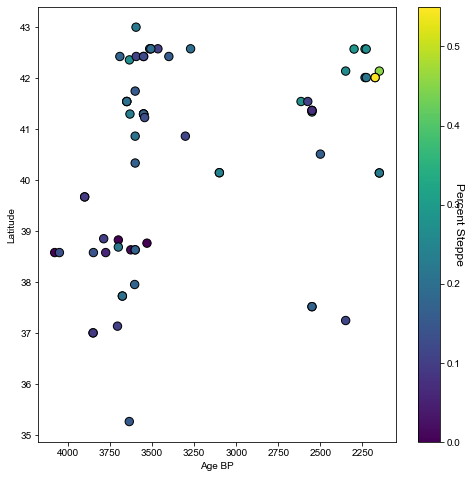

In [205]:
figsize = (8,8)
fs=12
x = df_all["age"]
y = df_all["lat"]
c = df_all["Fraction_3"].values

fig = plt.figure(figsize=figsize)
ax = plt.gca()
im = ax.scatter(x,y, c=c, ec="k", s=70)
ax.set_xlabel("Age BP")
ax.set_ylabel("Latitude")
ax.invert_xaxis()
cb = fig.colorbar(im, ax=ax)
cb.ax.set_ylabel("Percent Steppe", rotation=270, 
                 fontsize=fs)
plt.show()

intercept: -0.772672071983694
slope: 0.024406924714363114
coefficient of determination: 0.2184308729229626
Saved to ./output/figures/qpAdm/Steppe_Iberian_IA.pdf


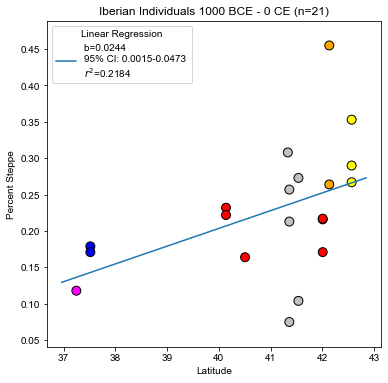

In [206]:
df_ba = df_all[df_all["age"]<3000].copy()  ## Cut off Age
df_ba = df_ba[df_ba["Fraction_3"]<0.5]
save_path="./output/figures/qpAdm/Steppe_Iberian_IA.pdf"

#x = df_ba["age"]
x = df_ba["lat"]
y = df_ba["Fraction_3"]
c = df_ba["color"]
figsize=(6,6)

### Do Linear Regression
idx = ~pd.isnull(x)
x_clean, y_clean = x[idx].values, y[idx].values
intercept, beta, r_sq, cis  = linear_regression(x_clean, y_clean)

### Plot the figure
fig = plt.figure(figsize=figsize)
ax = plt.gca()
im = ax.scatter(x, y, c=c, ec="k", s=80)

xlim = np.array(ax.get_xlim())
label = f"b={beta:.4f} \n95% CI: {cis[1,0]:.4f}-{cis[1,1]:.4f} \n$r^2$={r_sq:.4f}"
ax.plot(xlim, xlim*beta + intercept, label=label)
ax.legend(title="Linear Regression")

ax.set_xlabel("Latitude")
ax.set_ylabel("Percent Steppe")

ax.set_title(f"Iberian Individuals 1000 BCE - 0 CE (n={len(x)})")
if len(save_path) > 0:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0)
        print("Saved to %s" % save_path)
plt.show()

intercept: -0.3520089740695769
slope: 0.012447709935947775
coefficient of determination: 0.1252981184250901
Saved to ./output/figures/qpAdm/Steppe_Iberian_BA.pdf


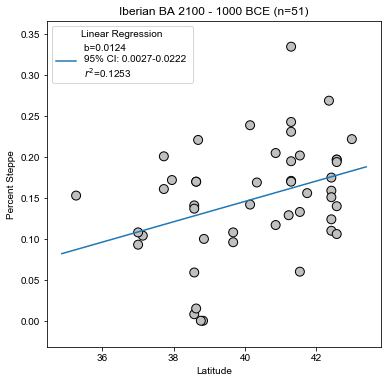

In [194]:
df_ba = df_all[df_all["age"]>3000].copy()  ## Cut off Age
df_ba = df_ba[df_ba["Fraction_3"]<0.45]
save_path="./output/figures/qpAdm/Steppe_Iberian_BA.pdf"

#x = df_ba["age"]
x = df_ba["lat"]
y = df_ba["Fraction_3"]
c = df_ba["color"]
figsize=(6,6)

### Do Linear Regression
idx = ~pd.isnull(x)
x_clean, y_clean = x[idx].values, y[idx].values
intercept, beta, r_sq, cis  = linear_regression(x_clean, y_clean)

### Plot the figure
fig = plt.figure(figsize=figsize)
ax = plt.gca()
im = ax.scatter(x, y, c=c, ec="k", s=80)

xlim = np.array(ax.get_xlim())
label = f"b={beta:.4f} \n95% CI: {cis[1,0]:.4f}-{cis[1,1]:.4f} \n$r^2$={r_sq:.4f}"
ax.plot(xlim, xlim*beta + intercept, label=label)
ax.legend(title="Linear Regression")

ax.set_xlabel("Latitude")
ax.set_ylabel("Percent Steppe")

ax.set_title(f"Iberian BA 2100 - 1000 BCE (n={len(x)})")

if len(save_path) > 0:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0)
        print("Saved to %s" % save_path)
        
plt.show()

# Area 51

In [22]:
df_all[df_all["target"].str.contains("I12640")]

,target,p-Value,Source_1,Source_2,Source_3,Fraction_1,Fraction_2,Fraction_3,STD_1,STD_2,...,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,color
60,I12640,0.869091,Anatolia_N,WHG,Steppe_EMBA,0.67,0.227,0.104,0.057,0.038,...,2.1329,2575.0,Spain,OlaldeScience2019,Iberia_IA,0.051249,61499,0.053317,True,silver


In [23]:
df_all.sort_values(by="Fraction_3")[:50]

,target,p-Value,Source_1,Source_2,Source_3,Fraction_1,Fraction_2,Fraction_3,STD_1,STD_2,...,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,color
33,I8566,-1.000000,Anatolia_N,WHG,Steppe_EMBA,0.000,0.000,0.000,0.000,0.000,...,-0.864165,3700.0,Spain,OlaldeScience2019,Iberia_BA,0.212202,254642,0.256849,True,silver
34,I8567,-1.000000,Anatolia_N,WHG,Steppe_EMBA,0.000,0.000,0.000,0.000,0.000,...,-0.586981,3530.0,Spain,OlaldeScience2019,Iberia_BA,0.132725,159270,0.145333,True,silver
4,I3485,0.079301,Anatolia_N,WHG,Steppe_EMBA,0.738,0.255,0.008,0.031,0.022,...,-2.841700,4078.0,Spain,OlaldeScience2019,Iberia_BA,0.383754,460505,0.608,True,silver
6,I3487,0.738388,Anatolia_N,WHG,Steppe_EMBA,0.727,0.258,0.015,0.051,0.036,...,-0.861500,3626.0,Spain,OlaldeScience2019,Iberia_BA,0.073043,87652,0.077,True,silver
41,pir001.SG,0.000057,Anatolia_N,WHG,Steppe_EMBA,0.705,0.258,0.037,0.048,0.034,...,NaN,3725.0,Spain,ValdioseraPNAS2018,Iberia_BA.SG,0.136787,164144,0.148705,True,silver
49,I12855,0.147221,Anatolia_N,WHG,Steppe_EMBA,0.681,0.260,0.059,0.085,0.063,...,-2.841700,3775.0,Spain,OlaldeScience2019,Iberia_BA,0.020212,24254,0.020366,True,silver
1,I1310,0.290870,Anatolia_N,WHG,Steppe_EMBA,0.692,0.248,0.060,0.032,0.023,...,2.132900,3650.0,Spain,OlaldeScience2019,Iberia_BA,0.345493,414591,0.539,True,silver
59,I12877,0.789135,Anatolia_N,WHG,Steppe_EMBA,0.638,0.286,0.075,0.067,0.043,...,1.669400,2550.0,Spain,OlaldeScience2019,Iberia_IA,0.039689,47627,0.041343,True,silver
31,I8141,0.569989,Anatolia_N,WHG,Steppe_EMBA,0.778,0.128,0.093,0.115,0.077,...,-3.894700,3850.0,Spain,OlaldeScience2019,Iberia_BA,0.013256,15907,0.013558,True,silver
28,I7692,0.616751,Anatolia_N,WHG,Steppe_EMBA,0.743,0.161,0.096,0.058,0.042,...,-8.130300,3900.0,Portugal,OlaldeScience2019,Iberia_BA,0.048707,58448,0.051515,True,silver


In [13]:
df_all.columns

Index(['target', 'p-Value', 'Source_1', 'Source_2', 'Source_3', 'Fraction_1',
       'Fraction_2', 'Fraction_3', 'STD_1', 'STD_2', 'STD_3', 'iid',
       'Master ID', 'lat', 'lon', 'age', 'region', 'study', 'clst', 'mean_cov',
       'n_cov_snp', 'avg_cov_snp', 'include_alt', 'color'],
      dtype='object')

In [15]:
df_ba = df_all[df_all["age"]>3000].copy()  ## Cut off Age
df_ba = df_ba[df_ba["Fraction_3"]<0.45]

In [17]:
df_ba.sort_values(by="fraction_2")

KeyError: 'fraction_2'